In [1]:
import cv2

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import numpy as np
import cv2
import pandas as pd

# ---- Device ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [24]:
variations = ["base", "normalized", "augmented", "augmented+regularized"]

In [ ]:
# ============================================================
# 1. DATASET VARIATIONS (same as feature extraction)
# ============================================================

def get_dataloaders(variation, batch_size=64, val_fraction=0.2, seed=42):
    """
    Returns: train_loader, val_loader, test_loader, test_dataset

    - variation: "base", "normalized", "augmented", or "augmented+regularized"
    - batch_size: batch size for training/validation
    - val_fraction: fraction of the original train set to use for validation
    """

    # --- Normalization (kept as in your original version) ---
    normalize = transforms.Normalize((0.5,), (0.5,))

    # --- Transforms (same as your previous version) ---
    base_transform = transforms.Compose([
        transforms.ToTensor()
    ])

    normalized_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    augment_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(24, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2),
        transforms.ToTensor(),
        normalize
    ])

    # --- Pick transform based on variation ---
    if variation == "base":
        transform_train = base_transform
        transform_test = base_transform
    elif variation == "normalized":
        transform_train = normalized_transform
        transform_test = normalized_transform
    elif variation == "augmented":
        transform_train = augment_transform
        transform_test = normalized_transform
    elif variation == "augmented+regularized":
        transform_train = augment_transform
        transform_test = augment_transform
    else:
        raise ValueError("Variation must be base, normalized, augmented, or augmented+regularized")

    # --- Datasets ---
    train_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform_train)
    test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform_test)

    # --- Train / Val split ---
    total_train = len(train_full)
    val_size = int(val_fraction * total_train)
    train_size = total_train - val_size

    # deterministic split (optional seed)
    generator = None
    try:
        generator = torch.Generator()
        generator.manual_seed(seed)
        train_dataset, val_dataset = random_split(train_full, [train_size, val_size], generator=generator)
    except Exception:
        train_dataset, val_dataset = random_split(train_full, [train_size, val_size])

    # Note: val_dataset currently uses transform_train (because it is a subset of train_full).
    # If you want val to use transform_test instead (e.g., no augmentation), replace its transform:
    # val_dataset.dataset.transform = transform_test

    # --- DataLoaders ---
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    return train_loader, val_loader, test_loader, test_dataset

In [ ]:
# ============================================================
# 2. RESNET ARCHITECTURE
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out = out + identity
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, variation="Base"):
        """
        variation: str — determines whether to apply dropout regularization
        Accepted values: 'Base', 'Normalized', 'Augmented', 'Augmented+Regularized'
        """
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 128, layers[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        dropout_rate = 0.5 if "Regularize" in variation else 0.0
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


In [5]:
# ============================================================
# 3. TRAINING FUNCTION (with Validation Tracking)
# ============================================================

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        # ==================== TRAIN ====================
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # ==================== VALIDATION ====================
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return history


In [6]:
# ============================================================
# 4. EVALUATION FUNCTION
# ============================================================

def evaluate_model(model, test_loader, device):
    model.eval()
    preds, labels_list = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    acc = accuracy_score(labels_list, preds)
    prec = precision_score(labels_list, preds, average='macro')
    rec = recall_score(labels_list, preds, average='macro')
    f1 = f1_score(labels_list, preds, average='macro')

    print(f"\nAccuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    cm = confusion_matrix(labels_list, preds)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return acc, prec, rec, f1

In [7]:
# ============================================================
# 5. GradCAM
# ============================================================

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach().clone()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_image, target_class=None):
        self.model.zero_grad()
        output = self.model(input_image)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        grads = self.gradients
        acts = self.activations
        weights = grads.mean(dim=(2, 3), keepdim=True)
        cam = (weights * acts).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam, target_class



==================== BASE ====================


Epoch 1/10 [Train]: 100%|██████████| 375/375 [00:09<00:00, 39.88it/s]


Epoch [1/10] | Train Loss: 0.1359 | Train Acc: 96.07% | Val Loss: 0.1344 | Val Acc: 95.95%


Epoch 2/10 [Train]: 100%|██████████| 375/375 [00:08<00:00, 42.70it/s]


Epoch [2/10] | Train Loss: 0.0435 | Train Acc: 98.64% | Val Loss: 0.0740 | Val Acc: 97.87%


Epoch 3/10 [Train]: 100%|██████████| 375/375 [00:10<00:00, 35.87it/s]


Epoch [3/10] | Train Loss: 0.0328 | Train Acc: 98.99% | Val Loss: 0.0391 | Val Acc: 98.78%


Epoch 4/10 [Train]: 100%|██████████| 375/375 [00:08<00:00, 43.82it/s]


Epoch [4/10] | Train Loss: 0.0245 | Train Acc: 99.25% | Val Loss: 0.0472 | Val Acc: 98.65%


Epoch 5/10 [Train]: 100%|██████████| 375/375 [00:08<00:00, 43.34it/s]


Epoch [5/10] | Train Loss: 0.0207 | Train Acc: 99.33% | Val Loss: 0.0384 | Val Acc: 98.92%


Epoch 6/10 [Train]: 100%|██████████| 375/375 [00:11<00:00, 33.36it/s]


Epoch [6/10] | Train Loss: 0.0188 | Train Acc: 99.38% | Val Loss: 0.0323 | Val Acc: 99.02%


Epoch 7/10 [Train]: 100%|██████████| 375/375 [00:08<00:00, 42.97it/s]


Epoch [7/10] | Train Loss: 0.0145 | Train Acc: 99.55% | Val Loss: 0.0384 | Val Acc: 98.94%


Epoch 8/10 [Train]: 100%|██████████| 375/375 [00:08<00:00, 42.73it/s]


Epoch [8/10] | Train Loss: 0.0133 | Train Acc: 99.57% | Val Loss: 0.0335 | Val Acc: 99.14%


Epoch 9/10 [Train]: 100%|██████████| 375/375 [00:10<00:00, 34.68it/s]


Epoch [9/10] | Train Loss: 0.0143 | Train Acc: 99.53% | Val Loss: 0.0292 | Val Acc: 99.12%


Epoch 10/10 [Train]: 100%|██████████| 375/375 [00:09<00:00, 41.43it/s]


Epoch [10/10] | Train Loss: 0.0104 | Train Acc: 99.64% | Val Loss: 0.0364 | Val Acc: 99.08%

Accuracy: 0.9916 | Precision: 0.9917 | Recall: 0.9914 | F1: 0.9916


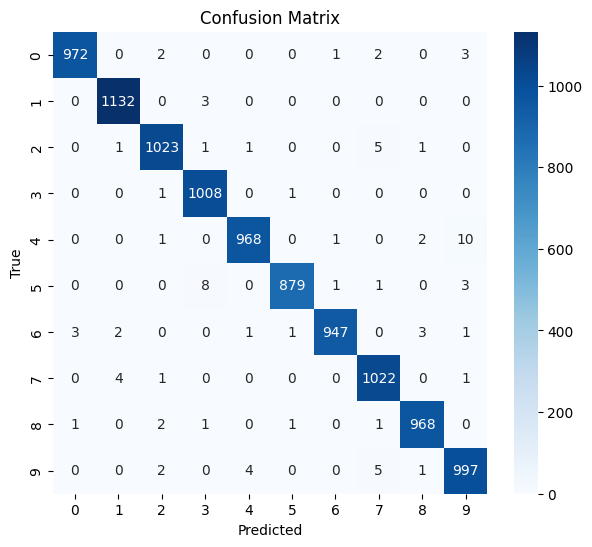


Final Test Results (BASE): Acc=0.99 | Prec=0.99 | Rec=0.99 | F1=0.99


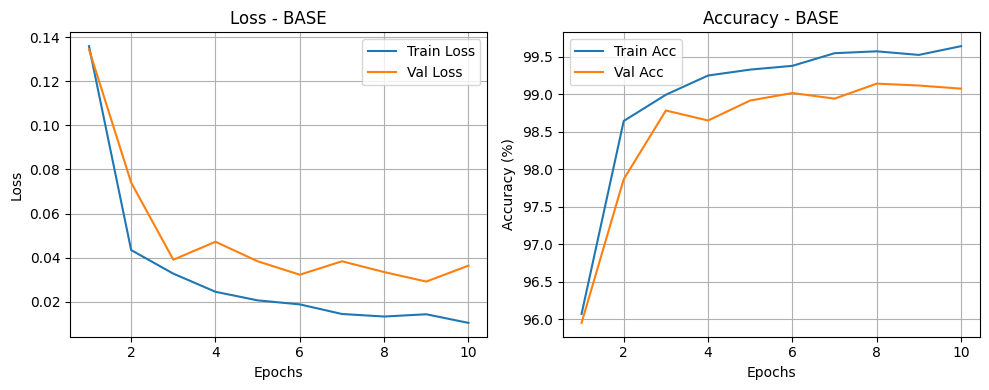

/tmp/ipykernel_9319/250618204.py:61: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_dataset.targets) == i)[0][0]
/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


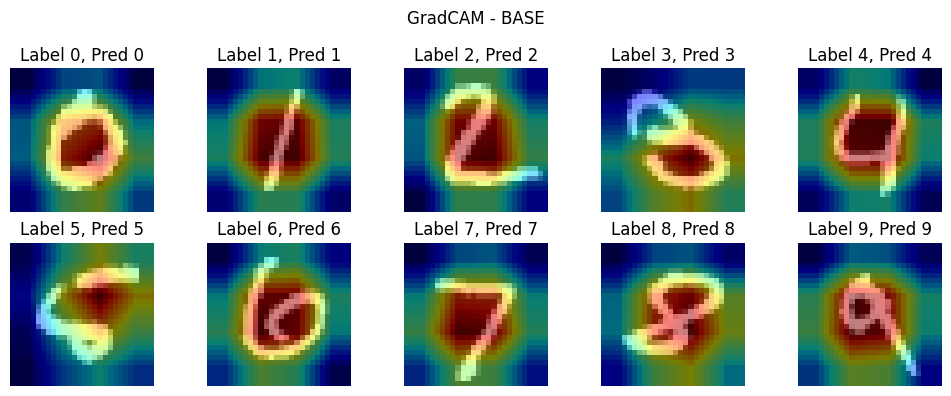


==================== NORMALIZED ====================


Epoch 1/10 [Train]: 100%|██████████| 375/375 [00:14<00:00, 26.52it/s]


Epoch [1/10] | Train Loss: 0.1401 | Train Acc: 95.93% | Val Loss: 0.0540 | Val Acc: 98.36%


Epoch 2/10 [Train]: 100%|██████████| 375/375 [00:14<00:00, 25.43it/s]


Epoch [2/10] | Train Loss: 0.0407 | Train Acc: 98.75% | Val Loss: 0.0472 | Val Acc: 98.62%


Epoch 3/10 [Train]: 100%|██████████| 375/375 [00:12<00:00, 31.14it/s]


Epoch [3/10] | Train Loss: 0.0294 | Train Acc: 99.16% | Val Loss: 0.0474 | Val Acc: 98.61%


Epoch 4/10 [Train]: 100%|██████████| 375/375 [00:15<00:00, 24.62it/s]


Epoch [4/10] | Train Loss: 0.0240 | Train Acc: 99.28% | Val Loss: 0.0478 | Val Acc: 98.69%


Epoch 5/10 [Train]: 100%|██████████| 375/375 [00:13<00:00, 28.74it/s]


Epoch [5/10] | Train Loss: 0.0209 | Train Acc: 99.32% | Val Loss: 0.0342 | Val Acc: 99.02%


Epoch 6/10 [Train]: 100%|██████████| 375/375 [00:15<00:00, 23.59it/s]


Epoch [6/10] | Train Loss: 0.0179 | Train Acc: 99.41% | Val Loss: 0.0282 | Val Acc: 99.11%


Epoch 7/10 [Train]: 100%|██████████| 375/375 [00:13<00:00, 27.15it/s]


Epoch [7/10] | Train Loss: 0.0148 | Train Acc: 99.54% | Val Loss: 0.0378 | Val Acc: 98.89%


Epoch 8/10 [Train]: 100%|██████████| 375/375 [00:16<00:00, 22.53it/s]


Epoch [8/10] | Train Loss: 0.0136 | Train Acc: 99.60% | Val Loss: 0.0345 | Val Acc: 98.99%


Epoch 9/10 [Train]: 100%|██████████| 375/375 [00:12<00:00, 29.82it/s]


Epoch [9/10] | Train Loss: 0.0104 | Train Acc: 99.70% | Val Loss: 0.0425 | Val Acc: 98.92%


Epoch 10/10 [Train]: 100%|██████████| 375/375 [00:16<00:00, 22.44it/s]


Epoch [10/10] | Train Loss: 0.0114 | Train Acc: 99.67% | Val Loss: 0.0450 | Val Acc: 98.67%

Accuracy: 0.9884 | Precision: 0.9884 | Recall: 0.9881 | F1: 0.9882


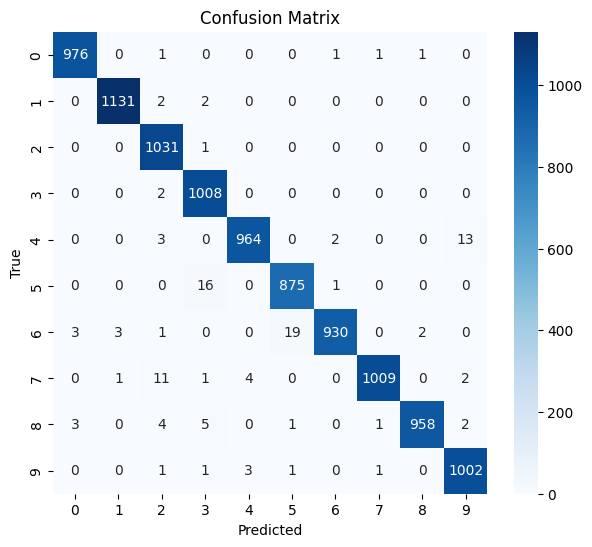


Final Test Results (NORMALIZED): Acc=0.99 | Prec=0.99 | Rec=0.99 | F1=0.99


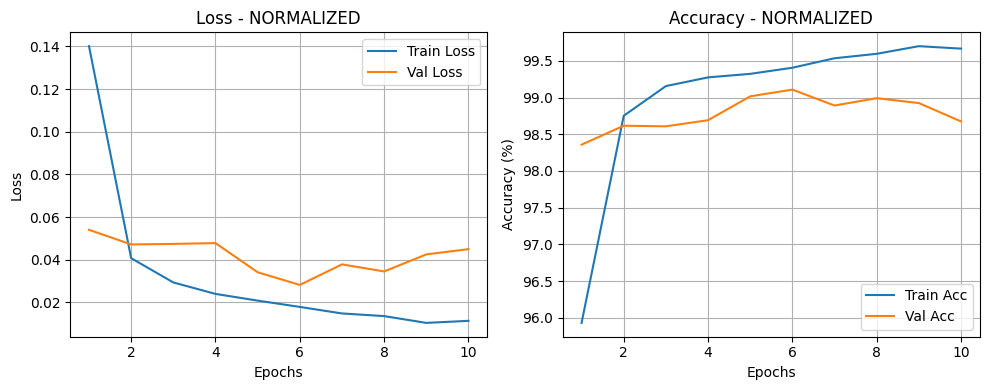

/tmp/ipykernel_9319/250618204.py:61: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_dataset.targets) == i)[0][0]
/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


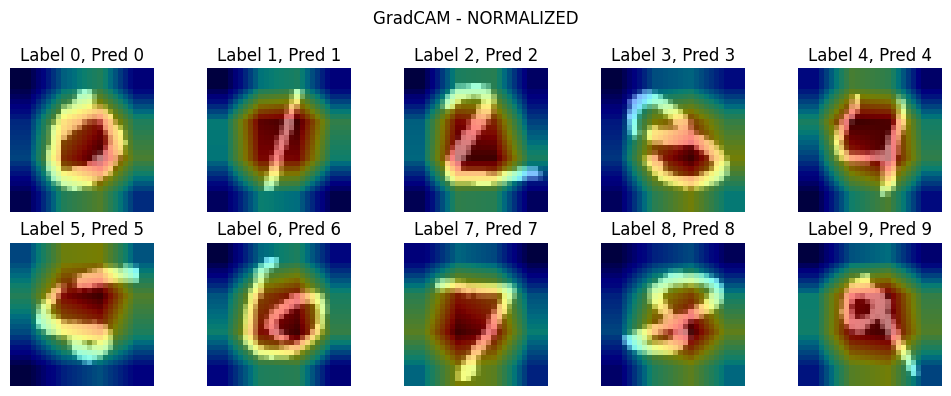


==================== AUGMENTED ====================


Epoch 1/10 [Train]: 100%|██████████| 375/375 [00:28<00:00, 13.24it/s]


Epoch [1/10] | Train Loss: 0.2610 | Train Acc: 91.86% | Val Loss: 0.1192 | Val Acc: 96.33%


Epoch 2/10 [Train]: 100%|██████████| 375/375 [00:27<00:00, 13.80it/s]


Epoch [2/10] | Train Loss: 0.0965 | Train Acc: 97.00% | Val Loss: 0.0994 | Val Acc: 96.91%


Epoch 3/10 [Train]: 100%|██████████| 375/375 [00:28<00:00, 13.01it/s]


Epoch [3/10] | Train Loss: 0.0733 | Train Acc: 97.72% | Val Loss: 0.0978 | Val Acc: 97.03%


Epoch 4/10 [Train]: 100%|██████████| 375/375 [00:26<00:00, 13.93it/s]


Epoch [4/10] | Train Loss: 0.0661 | Train Acc: 97.91% | Val Loss: 0.0622 | Val Acc: 98.09%


Epoch 5/10 [Train]: 100%|██████████| 375/375 [00:24<00:00, 15.20it/s]


Epoch [5/10] | Train Loss: 0.0588 | Train Acc: 98.09% | Val Loss: 0.0520 | Val Acc: 98.51%


Epoch 6/10 [Train]: 100%|██████████| 375/375 [00:24<00:00, 15.16it/s]


Epoch [6/10] | Train Loss: 0.0546 | Train Acc: 98.32% | Val Loss: 0.0776 | Val Acc: 97.62%


Epoch 7/10 [Train]: 100%|██████████| 375/375 [00:24<00:00, 15.37it/s]


Epoch [7/10] | Train Loss: 0.0516 | Train Acc: 98.36% | Val Loss: 0.0483 | Val Acc: 98.53%


Epoch 8/10 [Train]: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


Epoch [8/10] | Train Loss: 0.0506 | Train Acc: 98.31% | Val Loss: 0.0533 | Val Acc: 98.32%


Epoch 9/10 [Train]: 100%|██████████| 375/375 [00:26<00:00, 13.94it/s]


Epoch [9/10] | Train Loss: 0.0437 | Train Acc: 98.65% | Val Loss: 0.0454 | Val Acc: 98.54%


Epoch 10/10 [Train]: 100%|██████████| 375/375 [00:27<00:00, 13.48it/s]


Epoch [10/10] | Train Loss: 0.0446 | Train Acc: 98.57% | Val Loss: 0.0504 | Val Acc: 98.51%

Accuracy: 0.8678 | Precision: 0.9026 | Recall: 0.8661 | F1: 0.8638


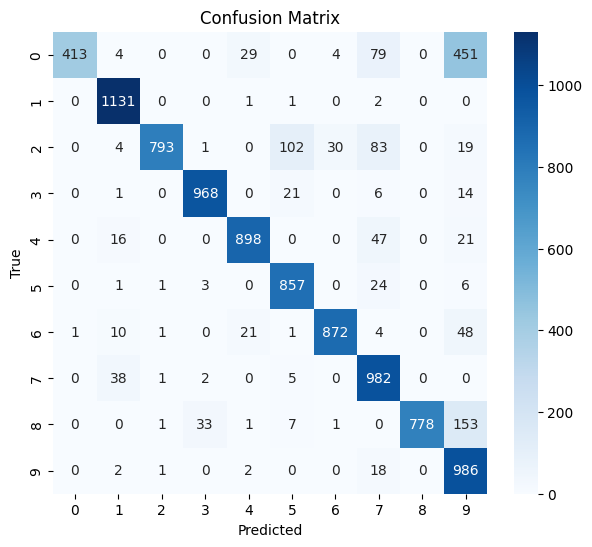


Final Test Results (AUGMENTED): Acc=0.87 | Prec=0.90 | Rec=0.87 | F1=0.86


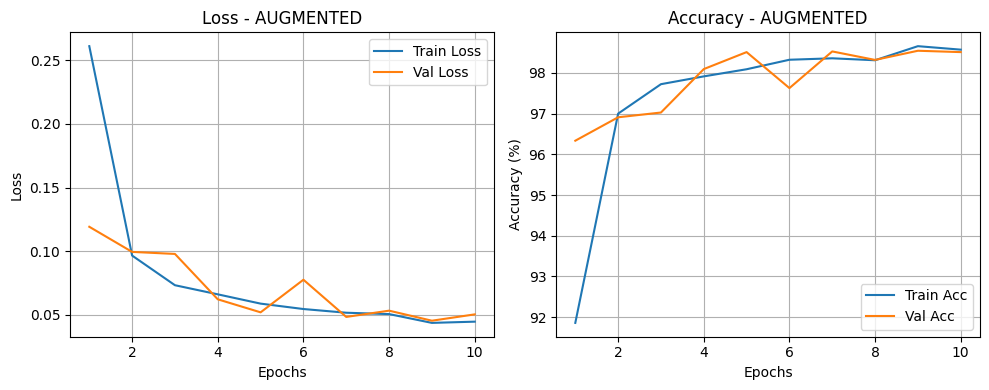

/tmp/ipykernel_9319/250618204.py:61: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_dataset.targets) == i)[0][0]
/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


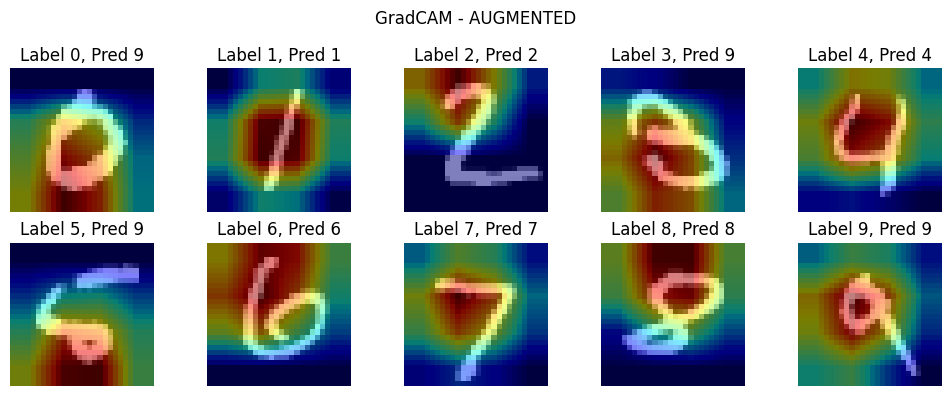


==================== AUGMENTED+REGULARIZED ====================


Epoch 1/10 [Train]: 100%|██████████| 375/375 [00:28<00:00, 13.35it/s]


Epoch [1/10] | Train Loss: 0.2611 | Train Acc: 91.63% | Val Loss: 0.1269 | Val Acc: 96.02%


Epoch 2/10 [Train]: 100%|██████████| 375/375 [00:27<00:00, 13.56it/s]


Epoch [2/10] | Train Loss: 0.0969 | Train Acc: 96.99% | Val Loss: 0.0967 | Val Acc: 96.97%


Epoch 3/10 [Train]: 100%|██████████| 375/375 [00:26<00:00, 14.13it/s]


Epoch [3/10] | Train Loss: 0.0764 | Train Acc: 97.66% | Val Loss: 0.0865 | Val Acc: 97.20%


Epoch 4/10 [Train]: 100%|██████████| 375/375 [00:26<00:00, 14.03it/s]


Epoch [4/10] | Train Loss: 0.0680 | Train Acc: 97.88% | Val Loss: 0.0659 | Val Acc: 98.00%


Epoch 5/10 [Train]: 100%|██████████| 375/375 [00:26<00:00, 14.23it/s]


Epoch [5/10] | Train Loss: 0.0598 | Train Acc: 98.12% | Val Loss: 0.0631 | Val Acc: 97.96%


Epoch 6/10 [Train]: 100%|██████████| 375/375 [00:27<00:00, 13.80it/s]


Epoch [6/10] | Train Loss: 0.0588 | Train Acc: 98.11% | Val Loss: 0.0622 | Val Acc: 97.90%


Epoch 7/10 [Train]: 100%|██████████| 375/375 [00:27<00:00, 13.82it/s]


Epoch [7/10] | Train Loss: 0.0545 | Train Acc: 98.28% | Val Loss: 0.0603 | Val Acc: 98.05%


Epoch 8/10 [Train]: 100%|██████████| 375/375 [00:27<00:00, 13.87it/s]


Epoch [8/10] | Train Loss: 0.0525 | Train Acc: 98.35% | Val Loss: 0.0614 | Val Acc: 98.13%


Epoch 9/10 [Train]: 100%|██████████| 375/375 [00:26<00:00, 13.89it/s]


Epoch [9/10] | Train Loss: 0.0498 | Train Acc: 98.47% | Val Loss: 0.0716 | Val Acc: 97.84%


Epoch 10/10 [Train]: 100%|██████████| 375/375 [00:27<00:00, 13.41it/s]


Epoch [10/10] | Train Loss: 0.0469 | Train Acc: 98.56% | Val Loss: 0.0527 | Val Acc: 98.41%

Accuracy: 0.8795 | Precision: 0.9025 | Recall: 0.8788 | F1: 0.8755


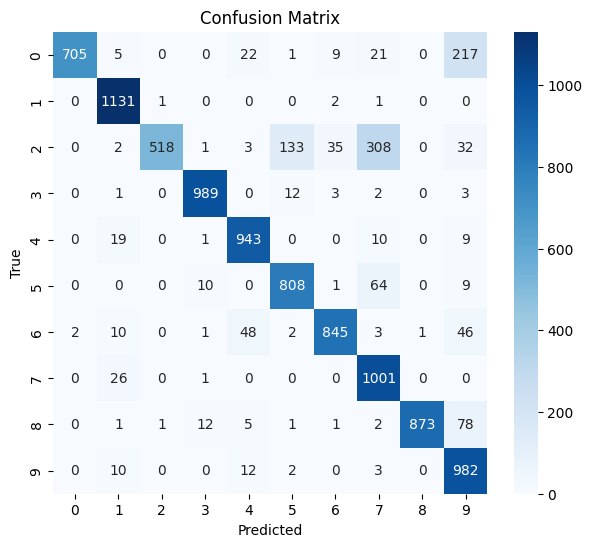


Final Test Results (AUGMENTED+REGULARIZED): Acc=0.88 | Prec=0.90 | Rec=0.88 | F1=0.88


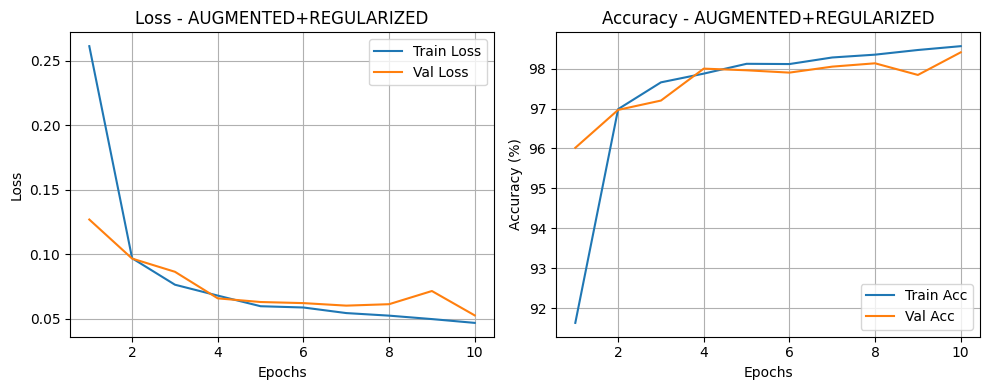

/tmp/ipykernel_9319/250618204.py:61: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_dataset.targets) == i)[0][0]
/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


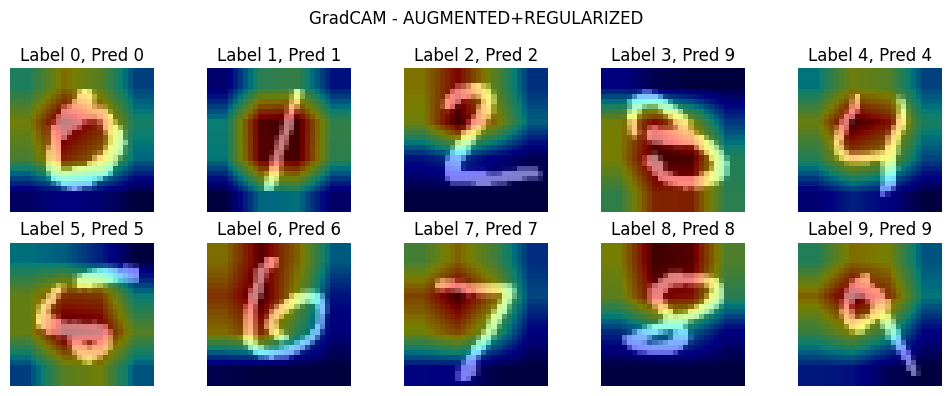

In [ ]:
# ============================================================
# 6. AUTOMATED TRAINING LOOP (All Variations)
# ============================================================
results = {}

for variation in variations:
    print(f"\n==================== {variation.upper()} ====================")
    
    # Load train/val/test sets
    train_loader, val_loader, test_loader, test_dataset = get_dataloaders(variation,batch_size=128, val_fraction=0.2, seed=42)

    model = ResNet(ResidualBlock, [2, 2, 2, 2], variation=variation).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(), lr=0.001,
        weight_decay=1e-4 if "regularized" in variation else 0
    )

    # --- Train model with validation ---
    history = train_model(model, train_loader, val_loader, criterion, optimizer, device = device, num_epochs=10)

    # --- Evaluate final performance on TEST data only ---
    acc, prec, rec, f1 = evaluate_model(model, test_loader, device)
    results[variation] = {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "history": history}

    print(f"\nFinal Test Results ({variation.upper()}): Acc={acc:.2f} | Prec={prec:.2f} | Rec={rec:.2f} | F1={f1:.2f}")

    # --- Plot metrics ---
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(10, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label="Train Loss")
    plt.plot(epochs, history['val_loss'], label="Val Loss")
    plt.title(f"Loss - {variation.upper()}")
    plt.xlabel("Epochs"); plt.ylabel("Loss")
    plt.legend(); plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label="Train Acc")
    plt.plot(epochs, history['val_acc'], label="Val Acc")
    plt.title(f"Accuracy - {variation.upper()}")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy (%)")
    plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

    # ---- Grad-CAM Visualizations ----
    grad_cam = GradCAM(model, model.layer4[-1].conv2)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    axes_flat = axes.flatten()

    for i in range(10):
        ax = axes_flat[i]
        idx = np.where(np.array(test_dataset.targets) == i)[0][0]
        img, _ = test_dataset[idx]
        input_tensor = img.unsqueeze(0).to(device)
        input_tensor.requires_grad_()
        cam, cls = grad_cam.generate(input_tensor)
        cam_resized = cv2.resize(cam, (img.shape[2], img.shape[1]))

        ax.imshow(img.squeeze().cpu().numpy(), cmap="gray")
        ax.imshow(cam_resized, cmap="jet", alpha=0.5)
        ax.set_title(f"Label {i}, Pred {cls}")
        ax.axis("off")

    plt.suptitle(f"GradCAM - {variation.upper()}")
    plt.tight_layout()
    plt.show()



In [10]:
import pickle

with open("results_resnet.pkl", "wb") as f:
    pickle.dump(results, f)


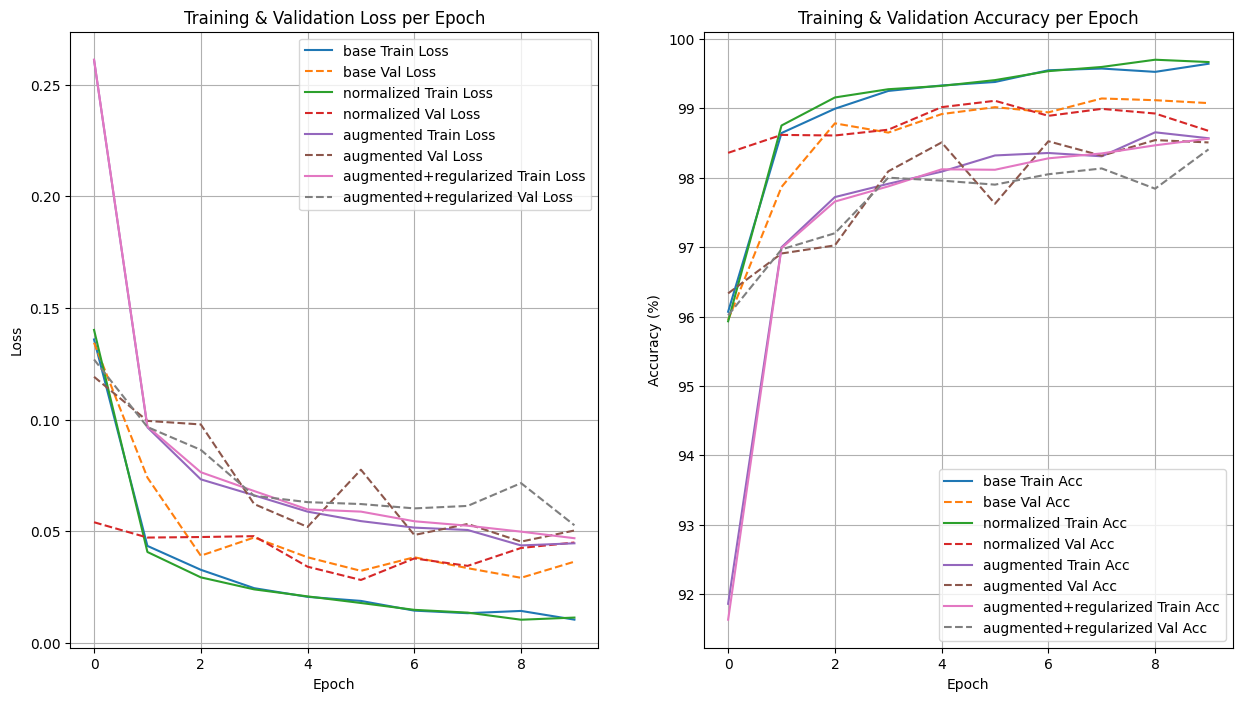

In [17]:
# ----------------------------
# Plot loss & accuracy curves for all variants
# ----------------------------
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)

for name, res in results.items():
    history = res["history"]
    plt.plot(history["train_loss"], label=f"{name} Train Loss")
    plt.plot(history["val_loss"], linestyle="--", label=f"{name} Val Loss")

plt.title("Training & Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
# plt.show()

# Plot accuracy curves
plt.subplot(1,2,2)
for name, res in results.items():
    history = res["history"]
    plt.plot(history["train_acc"], label=f"{name} Train Acc")
    plt.plot(history["val_acc"], linestyle="--", label=f"{name} Val Acc")

plt.title("Training & Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_9319/3645137118.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Variation", y="Test Accuracy", data=df, palette="viridis")


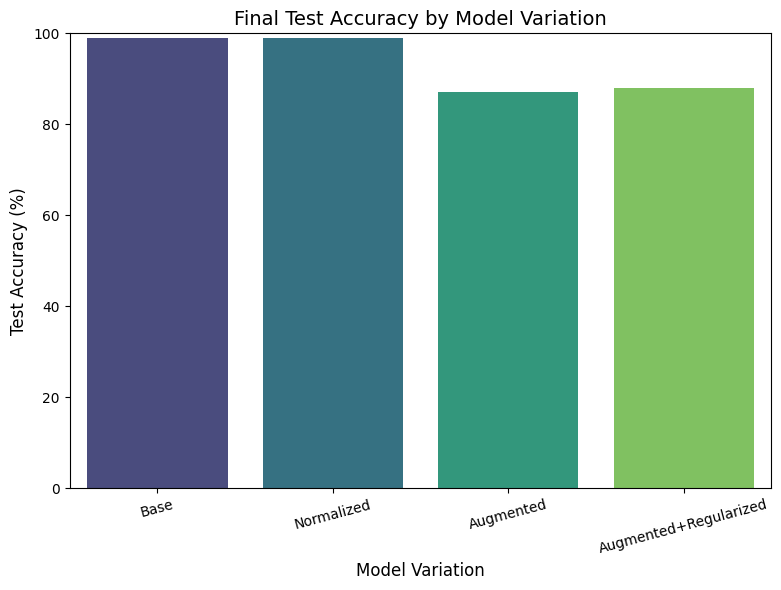

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example dictionary
results = {
    "Base": 99.0,
    "Normalized": 99.0,
    "Augmented": 87.0,
    "Augmented+Regularized": 88.0
}

# Convert to DataFrame for seaborn
df = pd.DataFrame(list(results.items()), columns=["Variation", "Test Accuracy"])

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x="Variation", y="Test Accuracy", data=df, palette="viridis")

plt.title("Final Test Accuracy by Model Variation", fontsize=14)
plt.xlabel("Model Variation", fontsize=12)
plt.ylabel("Test Accuracy (%)", fontsize=12)
plt.ylim(0, 100)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
